# Deep GP supervised learning

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import deepgp
import GPy
import numpy as np
%matplotlib inline
from pylab import *

In [2]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

In [3]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

Acquiring resource: olympic_marathon_men

Details of data: 
Olympic mens' marathon gold medal winning times from 1896 to 2012. Time given in pace (minutes per kilometer). Data is originally downloaded and collated from Wikipedia, we are not responsible for errors in the data

After downloading the data will take up 584 bytes of space.

Data will be stored in /Users/lawrennd/tmp/GPy-datasets/olympic_marathon_men.

Do you wish to proceed with the download? [yes/no]
yes
olympicMarathonTimes.csv
[==============================]   0.001/0.001MB                                                


In [4]:
m = deepgp.DeepGP([y.shape[1],5,x.shape[1]],Y=y, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(5,ARD=True),GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)
m.obslayer.likelihood.variance[:] = y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)
print(m)


Name : deepgp
Objective : 861.2417113363451
Number of Parameters : 680
Number of Optimization Parameters : 676
Updates : True
Parameters:
  deepgp.                           |             value  |  constraints  |  priors
  obslayer.inducing_inputs          |           (50, 5)  |               |        
  obslayer.rbf.variance             |               1.0  |   +ve fixed   |        
  obslayer.rbf.lengthscale          |              (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |  0.00285998869872  |   +ve fixed   |        
  obslayer.Kuu_var                  |             (50,)  |      +ve      |        
  obslayer.latent_space.mean        |           (27, 5)  |               |        
  obslayer.latent_space.variance    |           (27, 5)  |      +ve      |        
  layer_1.inducing_inputs           |           (50, 1)  |               |        
  layer_1.rbf.variance              |               1.0  |   +ve fixed   |        
  layer_1.rbf.lengthscale      

In [5]:
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=10000)

In [6]:
print(m)


Name : deepgp
Objective : 17.345529248770163
Number of Parameters : 680
Number of Optimization Parameters : 680
Updates : True
Parameters:
  deepgp.                           |              value  |  constraints  |  priors
  obslayer.inducing_inputs          |            (50, 5)  |               |        
  obslayer.rbf.variance             |      27.9588844697  |      +ve      |        
  obslayer.rbf.lengthscale          |               (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |   0.00410605913376  |      +ve      |        
  obslayer.Kuu_var                  |              (50,)  |      +ve      |        
  obslayer.latent_space.mean        |            (27, 5)  |               |        
  obslayer.latent_space.variance    |            (27, 5)  |      +ve      |        
  layer_1.inducing_inputs           |            (50, 1)  |               |        
  layer_1.rbf.variance              |  0.000702239064208  |      +ve      |        
  layer_1.rbf.length

In [7]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],0.26066207,+ve,
[1],43.49754919,+ve,
[2],43.62949444,+ve,
[3],43.47473531,+ve,
[4],43.30625478,+ve,


### Plot the prediction

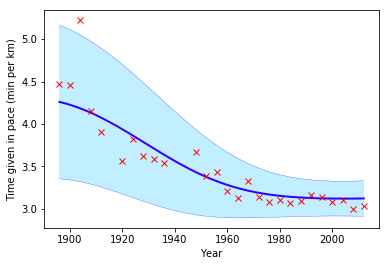

In [8]:
xt = np.linspace(x.min(),x.max(),200)[:,None]
yt = m.predict(xt)
gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]))
plot(x,y,'rx')
xlabel('Year')
_=ylabel('Time given in pace (min per km)')

### Fitted GP for each layer

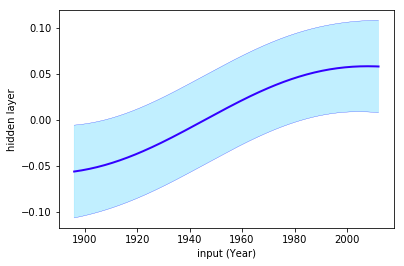

In [9]:
xt = np.linspace(x.min(),x.max(),200)[:,None]
yt = m.layer_1.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('input (Year)')
_=ylabel('hidden layer')

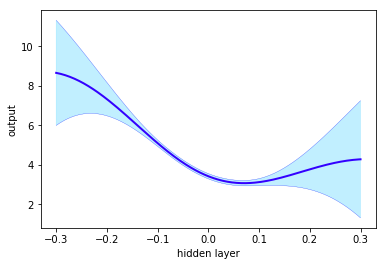

In [10]:
xt = np.zeros((200,5))
xt[:,0] = np.linspace(-0.3,0.3,200)
yt = m.obslayer.predict(xt)
gpplot(xt[:,0],yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]))
xlabel('hidden layer')
_=ylabel('output')